In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as tf_keras

In [5]:
(x_train, y_train), (x_test, y_test) = tf_keras.datasets.cifar10.load_data()

In [6]:
x_train.shape

(50000, 32, 32, 3)

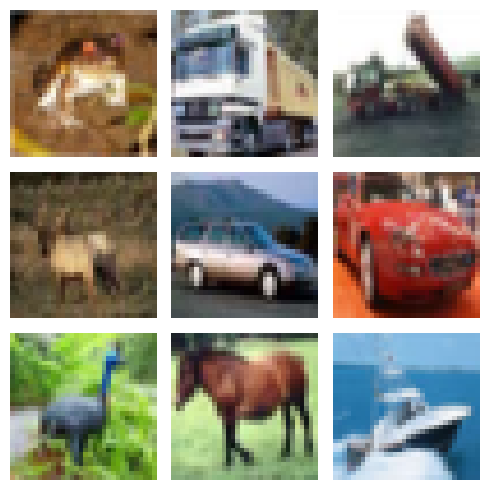

In [7]:
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [8]:
print(np.unique(y_train))

[0 1 2 3 4 5 6 7 8 9]


In [9]:
x_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

In [10]:
# 학습데이터 준비

x_train_dog = x_train[y_train.flatten() == 5] # 강아지 이미지만 뽑기
#x_train_dog = x_train[y_train.reshape(-1) == 5] # 강아지 이미지만 뽑기

x_train_dog.shape, x_train_dog.max(), x_train_dog.min()

x_train_dog_scaled = x_train_dog / x_train_dog.max()

print(x_train_dog_scaled.dtype)

x_train_dog_scaled2 = x_train_dog_scaled.astype('float32')

print(x_train_dog_scaled2.dtype)

## 왜 y_train은 안만들어주는가 -> 정답을 맞추고 안맞추고가 중요한게 아니라 
## 새로운 이미지를 만드는 지가 중요

float64
float32


In [11]:
#파라미터 설정
width = 32
height = 32
channels = 3
latent_dim = 32 # 이미지 생성을 위한 초기 데이터를 추출하는 공간

In [12]:
#판별모델 구조 설계

d_input = tf_keras.layers.Input(shape=(width, height, channels))
d_x = tf_keras.layers.Conv2D(filters = 32, kernel_size = 3)(d_input)
d_x = tf_keras.layers.LeakyReLU()(d_x) # 0아래값이 소멸되지 않게 기울기를 주는 함수
d_x = tf_keras.layers.Conv2D(filters = 64, kernel_size = 3)(d_x)
d_x = tf_keras.layers.LeakyReLU()(d_x)
d_x = tf_keras.layers.Conv2D(filters = 64, kernel_size = 3)(d_x)
d_x = tf_keras.layers.LeakyReLU()(d_x)
d_x = tf_keras.layers.Flatten()(d_x)
d_output = tf_keras.layers.Dense(units = 1, activation = "sigmoid")(d_x)

discriminator = tf_keras.models.Model(inputs = d_input, outputs = d_output)

discriminator.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 30, 30, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 64)        36928     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 26, 26, 64)        0    

In [14]:
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
#생성모델 구조 설계
g_input = tf_keras.layers.Input(shape=(latent_dim,))
g_x = tf_keras.layers.Dense(units = 128 * 16 * 16)(g_input) # 채널수 * 이미지크기(16*16)
g_x = tf_keras.layers.LeakyReLU()(g_x)
g_x = tf_keras.layers.Reshape(target_shape=(16, 16, 128))(g_x)
g_x = tf_keras.layers.Conv2D(filters = 256, kernel_size = 4, padding= "same")(g_x)
g_x = tf_keras.layers.LeakyReLU()(g_x)

#Conv2DTranspose 이미지 확대 (width * stride, height * stride) padding이 "same" 일 경우
g_x = tf_keras.layers.Conv2DTranspose(filters = 256, kernel_size = 4, strides = 2, padding= "same")(g_x) 
g_x = tf_keras.layers.LeakyReLU()(g_x)

g_x = tf_keras.layers.Conv2D(filters = 256, kernel_size = 4, padding= "same")(g_x)
g_x = tf_keras.layers.LeakyReLU()(g_x)
g_x = tf_keras.layers.Conv2D(filters = 256, kernel_size = 4, padding= "same")(g_x)
g_x = tf_keras.layers.LeakyReLU()(g_x)

g_output = tf_keras.layers.Conv2D(filters = channels, kernel_size = 5, padding= "same", activation = "sigmoid")(g_x)

generator = tf_keras.models.Model(inputs = g_input, outputs = g_output)

generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_1 (Dense)             (None, 32768)             1081344   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 256)       524544    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 32, 256)       1048

In [16]:
#전체 모델 구조 설계

discriminator.trainable = False # 가중치 업데이트 수행 X 그러나 단독합습일 경우에는 가중치 업데이트함

gen_input = tf_keras.layers.Input(shape= (latent_dim) )
gen_x = generator(gen_input)
gen_output = discriminator(gen_x)

gen_model = tf_keras.models.Model(inputs = gen_input, outputs = gen_output)

gen_model.compile(loss= "binary_crossentropy", optimizer = "adam")

gen_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32)]              0         
                                                                 
 model_1 (Functional)        (None, 32, 32, 3)         4771587   
                                                                 
 model (Functional)          (None, 1)                 99585     
                                                                 
Total params: 4871172 (18.58 MB)
Trainable params: 4771587 (18.20 MB)
Non-trainable params: 99585 (389.00 KB)
_________________________________________________________________


In [18]:
import os

image_path = "generated_images"
if not os.path.exists(image_path):
    os.mkdir(image_path)

iterations =  1000
batch_size =  32
start      =  0
for step in range(iterations):

    # 잠재공간에서 이미지로 복원(생성)할 난수 발생 (32개의 이미지)
    random_latent_vectors = np.random.normal( size=(batch_size, latent_dim) )
    
    #이미지 만들기
    generated_images = generator.predict( random_latent_vectors )

    # (32, 32, 32, 3) 구조확인
    print(generated_images.shape) 

    #실제이미지 가져오기, 라벨작업 (실제이미지 1, 생성이미지 0)
    real_images = x_train_dog_scaled2[ start : start + batch_size ]
    labels = np.concatenate([ np.ones((batch_size, 1)), np.zeros((batch_size, 1)) ])
    labels += np.random.random(labels.shape) * 0.05 # 제작자의 경험에 의한 학습효율 증가 구현

    #이미지 합치기
    combined_images = np.concatenate( [real_images, generated_images] )

    d_loss = discriminator.train_on_batch(combined_images, labels)

    random_latent_vectors2 = np.random.normal( size=(batch_size, latent_dim) )
    labels2 = np.ones((batch_size, 1))

    g_loss = gen_model.train_on_batch(random_latent_vectors2, labels2)

    start += batch_size

    #남은 이미지가 32개 이하인 경우 start 초기화
    if start > x_train_dog_scaled2.shape[0] - batch_size:
        start = 0
    if (step > 0 and step % 50 == 0):
        img = tf_keras.preprocessing.image.array_to_img(generated_images[0]*255, scale=False)
        img.save(os.path.join(image_path, f'generated_images_{step}.png'))
        img = tf_keras.preprocessing.image.array_to_img(real_images[0]*255, scale=False)
        img.save(os.path.join(image_path, f'real_images_{step}.png'))

1/1 [==============================] - 1s 676ms/step
(32, 32, 32, 3)


1/1 [==============================] - 1s 613ms/step
(32, 32, 32, 3)
1/1 [==============================] - 1s 538ms/step
(32, 32, 32, 3)
1/1 [==============================] - 1s 630ms/step
(32, 32, 32, 3)
1/1 [==============================] - 1s 546ms/step
(32, 32, 32, 3)
1/1 [==============================] - 1s 622ms/step
(32, 32, 32, 3)
1/1 [==============================] - 1s 544ms/step
(32, 32, 32, 3)
1/1 [==============================] - 1s 599ms/step
(32, 32, 32, 3)
1/1 [==============================] - 1s 663ms/step
(32, 32, 32, 3)
1/1 [==============================] - 1s 651ms/step
(32, 32, 32, 3)
1/1 [==============================] - 1s 544ms/step
(32, 32, 32, 3)
1/1 [==============================] - 1s 717ms/step
(32, 32, 32, 3)
1/1 [==============================] - 1s 652ms/step
(32, 32, 32, 3)
1/1 [==============================] - 1s 695ms/step
(32, 32, 32, 3)
1/1 [===========================